# Web Scraping and Linear Regression with Car Data

Purpose: web scrape used car data and estimate pricing based on car attributes like age, mileage, color, and model type

In [1]:
# bs4=BeautifulSoup for parsing the HTML text returned from a URL
# requests gets our HTML text

import bs4
import requests
import pandas as pd
from datetime import datetime

# Scraping a single URL

Note: 
* 05/29/20: These links may rot as cars get sold. Go to CarFax.com, apply a few search filters, and click on several cars of interest.
* In this example, we use the Honda Civic for year 2017 or higher

In [2]:
# the soup object contains the full HTML text and car attributes
url = 'https://www.carfax.com/vehicle/2HGFC3A56KH750872'
resp = requests.get(url)
soup = bs4.BeautifulSoup(resp.text)

print(resp.text[:1000], end='\n\n')
print(type(soup))

<!DOCTYPE html>
<html>

<head>
  <title data-react-helmet="true">2HGFC3A56KH750872 | 2019 Honda Civic Si for sale in Joliet, IL </title>
  <link rel='dns-prefetch' href='https://media.carfax.com' />
  <link rel='dns-prefetch' href='https://static.carfax.com' />
  <link rel='preconnect' crossorigin='true' href='https://carfax-img.vast.com' />
  <link rel="manifest" href="/manifest.json" />
  <link rel="apple-touch-icon" href="https://static.carfax.com/uclassets/images/favicon-228.png">
  <link rel="apple-touch-startup-image" href="https://static.carfax.com/uclassets/images/favicon-228.png">
  <meta name="theme-color" content="#3777bc"/>
  <meta http-equiv="X-UA-Compatible" content="IE=edge" />
  <meta charset="UTF-8" />
  <script type='text/javascript' >window.NREUM||(NREUM={});NREUM.info = {"agent":"","beacon":"bam.nr-data.net","errorBeacon":"bam.nr-data.net","licenseKey":"c882024f46","applicationID":"53224171","applicationTime":652.851756,"transactionName":"M1EBYkcEDEpQBk1QDQobJk5FFwd

In [3]:
# use soup selecters to narrow down to HTML containing data 
soup.select('.vehicle-info-details')

[<div class="vehicle-info-details vehicle-info-details-title">Price </div>,
 <div class="vehicle-info-details-price vehicle-info-details">$21,000</div>,
 <div class="vehicle-info-details vehicle-info-details-title">Mileage </div>,
 <div class="vehicle-info-details">16,788 miles </div>,
 <div class="vehicle-info-details vehicle-info-details-title">Location </div>,
 <div class="vehicle-info-details">Joliet, IL </div>,
 <div class="vehicle-info-details vehicle-info-details-title">Exterior Color </div>,
 <div class="vehicle-info-details">Blue</div>,
 <div class="vehicle-info-details vehicle-info-details-title">Interior Color </div>,
 <div class="vehicle-info-details">Black</div>,
 <div class="vehicle-info-details vehicle-info-details-title">Drive Type </div>,
 <div class="vehicle-info-details">FWD</div>,
 <div class="vehicle-info-details vehicle-info-details-title">Transmission </div>,
 <div class="vehicle-info-details">Manual</div>,
 <div class="vehicle-info-details vehicle-info-details-t

In [4]:
# parse data points of interest

# multiple assignment trick
    # the '*_' assigns an arbitrary number of elements that we don't care about to '_'
    # idiom for throw-away variables that we don't use is the '_' single underscore character 

# price, mileage, etc are 'tag' elements
_, price, _, mileage, _, loc, _, color_ext, *_ = soup.select('.vehicle-info-details')
price, mileage, loc, color_ext

(<div class="vehicle-info-details-price vehicle-info-details">$21,000</div>,
 <div class="vehicle-info-details">16,788 miles </div>,
 <div class="vehicle-info-details">Joliet, IL </div>,
 <div class="vehicle-info-details">Blue</div>)

In [5]:
# get text from from tag elements via tag.getText() and store in dictionary format

columns=['price', 'mileage', 'loc', 'color_ext']
data_vals = [xtag.getText() for xtag in [price, mileage, loc, color_ext]]
data = zip(columns, data_vals)
data = dict(data)
data

{'price': '$21,000',
 'mileage': '16,788 miles ',
 'loc': 'Joliet, IL ',
 'color_ext': 'Blue'}

In [6]:
# convert dictionary to dataframe

df = pd.DataFrame.from_dict(data, orient='index').T
df['url'] = url
df

,price,mileage,loc,color_ext,url
0,"$21,000","16,788 miles","Joliet, IL",Blue,https://www.carfax.com/vehicle/2HGFC3A56KH750872


# Make this a function, loop through a list of URLs, and consolidate

In [7]:
def url_to_df(url):
    '''Parse data from carfax url

    Example
    -------
    >>> url = 'https://www.carfax.com/vehicle/SHHFK7H48JU208178'
    >>> df = parse_url(url)
    '''
    resp = requests.get(url)
    try:
        resp.raise_for_status()
    except:
        print(f'HTTP Error for URL: {url}')
        return None
    soup = bs4.BeautifulSoup(resp.text)
    _, price, _, mileage, _, loc, _, color_ext, *_ = soup.select('.vehicle-info-details')
    columns=['price', 'mileage', 'loc', 'color_ext']
    data_vals = [x.getText() for x in [price, mileage, loc, color_ext]]
    data = zip(columns, data_vals)
    data = dict(data)
    df = pd.DataFrame.from_dict(data, orient='index').T
    df['mileage'] = df['mileage'].str.replace(' miles', '')
    df['url'] = url
    df['label'] = soup.select('.vehicle-title')[0].getText()
    df['year'] = df['label'].str.slice(0,4)
    df = df[['label', 'year', 'mileage', 'price', 'color_ext', 'loc', 'url']]
    return df


In [8]:
urls = ['https://www.carfax.com/vehicle/2HGFC2F6XKH516438',
 'https://www.carfax.com/vehicle/19XFB2F52FE095230',
 'https://www.carfax.com/vehicle/SHHFK7H57JU237048',
 'https://www.carfax.com/vehicle/SHHFK7H54JU209689',
 'https://www.carfax.com/vehicle/19XFB2F71FE024814',
 'https://www.carfax.com/vehicle/2HGFC3A56KH750872',
 'https://www.carfax.com/vehicle/19XFC1F31HE017014',
 'https://www.carfax.com/vehicle/2HGFC3B70HH361556',
 'https://www.carfax.com/vehicle/2HGFC4B60KH304679',
 'https://www.carfax.com/vehicle/SHHFK7H42HU211538',
 'https://www.carfax.com/vehicle/SHHFK7H56HU232918',
 'https://www.carfax.com/vehicle/19XFA1F50BE030688',
 'https://www.carfax.com/vehicle/2HGFC3B39JH352003',
 'https://www.carfax.com/vehicle/19XFC2F57JE025910',
 'https://www.carfax.com/vehicle/2HGFC4B50GH301957',
 'https://www.carfax.com/vehicle/2HGFC3B72JH351813',
 'https://www.carfax.com/vehicle/19XFB2F50FE059830',
 'https://www.carfax.com/vehicle/19XFC2F59JE007764',
 'https://www.carfax.com/vehicle/19XFB2F56FE114488',
 'https://www.carfax.com/vehicle/19XFC2F50HE075008',
 'https://www.carfax.com/vehicle/2HGFC3B32GH351929',
 'https://www.carfax.com/vehicle/2HGFC3B34HH355773',
 'https://www.carfax.com/vehicle/2HGFC2F71HH525403',
 'https://www.carfax.com/vehicle/19XFC2F5XHE034790']

In [9]:
# initialize empty dataframe and concatenate new sub dataframes with itself
df_all = pd.DataFrame()
for url in urls:
    print(url)
    df_sub = url_to_df(url)
    df_all = pd.concat([df_all, df_sub])

df_all = df_all.reset_index(drop=True)

# convert price string to integer 
df_all['price'] = df_all['price'].str.replace('$','').str.replace(',','').astype(int)

https://www.carfax.com/vehicle/2HGFC2F6XKH516438
https://www.carfax.com/vehicle/19XFB2F52FE095230
https://www.carfax.com/vehicle/SHHFK7H57JU237048
HTTP Error for URL: https://www.carfax.com/vehicle/SHHFK7H57JU237048
https://www.carfax.com/vehicle/SHHFK7H54JU209689
https://www.carfax.com/vehicle/19XFB2F71FE024814
https://www.carfax.com/vehicle/2HGFC3A56KH750872
https://www.carfax.com/vehicle/19XFC1F31HE017014
https://www.carfax.com/vehicle/2HGFC3B70HH361556
https://www.carfax.com/vehicle/2HGFC4B60KH304679
HTTP Error for URL: https://www.carfax.com/vehicle/2HGFC4B60KH304679
https://www.carfax.com/vehicle/SHHFK7H42HU211538
https://www.carfax.com/vehicle/SHHFK7H56HU232918
HTTP Error for URL: https://www.carfax.com/vehicle/SHHFK7H56HU232918
https://www.carfax.com/vehicle/19XFA1F50BE030688
https://www.carfax.com/vehicle/2HGFC3B39JH352003
https://www.carfax.com/vehicle/19XFC2F57JE025910
HTTP Error for URL: https://www.carfax.com/vehicle/19XFC2F57JE025910
https://www.carfax.com/vehicle/2HGFC4B

In [10]:
df_all

,label,year,mileage,price,color_ext,loc,url
0,2019 Honda Civic LX,2019,"9,082",16499,Gray,"Crystal Lake, IL",https://www.carfax.com/vehicle/2HGFC2F6XKH516438
1,2015 Honda Civic LX,2015,"89,895",8995,Black,"Addison, IL",https://www.carfax.com/vehicle/19XFB2F52FE095230
2,2018 Honda Civic EX,2018,"23,027",18900,Black,"Joliet, IL",https://www.carfax.com/vehicle/SHHFK7H54JU209689
3,2015 Honda Civic SE,2015,"75,326",9995,White,"Addison, IL",https://www.carfax.com/vehicle/19XFB2F71FE024814
4,2019 Honda Civic Si,2019,"16,788",21000,Blue,"Joliet, IL",https://www.carfax.com/vehicle/2HGFC3A56KH750872
5,2017 Honda Civic EX-T,2017,"22,041",16999,Blue,"Crystal Lake, IL",https://www.carfax.com/vehicle/19XFC1F31HE017014
6,2017 Honda Civic EXL,2017,"24,137",17000,Black,"Joliet, IL",https://www.carfax.com/vehicle/2HGFC3B70HH361556
7,2017 Honda Civic Sport,2017,"62,362",15500,Silver,"Elgin, IL",https://www.carfax.com/vehicle/SHHFK7H42HU211538
8,2011 Honda Civic LX,2011,"98,088",7500,Gray,"Mchenry, IL",https://www.carfax.com/vehicle/19XFA1F50BE030688
9,2018 Honda Civic EX-T,2018,"21,222",17499,Gray,"Gurnee, IL",https://www.carfax.com/vehicle/2HGFC3B39JH352003


# Predictive model using ordinary least squares regression (OLS)

### Primer
* Relationship between dependent variable (value we want to predict)
* Constant/intercept
* Slope coefficient
* Random error term

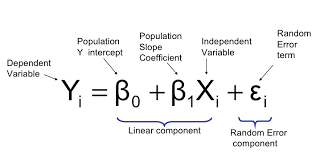

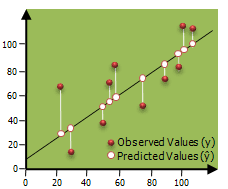

![image.png](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR-tWrEwqgBkxDc2KOkS-RvsLd6b4XTUdQ9LsdWrhS65UCGY8I7&usqp=CAU)

### Prepare model inputs
* note that we omit 1 of the model dummy variables
* use n-1 dummy variables where n=number of unique categories
* reference
    * https://stats.stackexchange.com/questions/115049/why-do-we-need-to-dummy-code-categorical-variables

In [11]:
# y is independent variable to predict that depends on X's
# convention is capital X for predictor variables

y = df_all['price']
X = pd.DataFrame(index=df_all.index)

# format X variables 
X['age'] = datetime.today().year - df_all['year'].astype(int)
X['mileage'] = df_all['mileage'].str.replace(',','').astype(int)
# X['dummy_lx'] = df_all['label'].str.lower().str.contains('lx').astype(int)
X['dummy_ex'] = df_all['label'].str.lower().str.contains('ex').astype(int)
X['dummy_si'] = df_all['label'].str.lower().str.contains('si').astype(int)
X['dummy_sport'] = df_all['label'].str.lower().str.contains('sport').astype(int)

In [12]:
X.head(10)

,age,mileage,dummy_ex,dummy_si,dummy_sport
0,1,9082,0,0,0
1,5,89895,0,0,0
2,2,23027,1,0,0
3,5,75326,0,0,0
4,1,16788,0,1,0
5,3,22041,1,0,0
6,3,24137,1,0,0
7,3,62362,0,0,1
8,9,98088,0,0,0
9,2,21222,1,0,0


In [13]:
# merge to view prepared variables with original dataframe
merged = df_all.merge(X, left_index=True, right_index=True)
merged.head(10).drop(columns='url')

,label,year,mileage_x,price,color_ext,loc,age,mileage_y,dummy_ex,dummy_si,dummy_sport
0,2019 Honda Civic LX,2019,"9,082",16499,Gray,"Crystal Lake, IL",1,9082,0,0,0
1,2015 Honda Civic LX,2015,"89,895",8995,Black,"Addison, IL",5,89895,0,0,0
2,2018 Honda Civic EX,2018,"23,027",18900,Black,"Joliet, IL",2,23027,1,0,0
3,2015 Honda Civic SE,2015,"75,326",9995,White,"Addison, IL",5,75326,0,0,0
4,2019 Honda Civic Si,2019,"16,788",21000,Blue,"Joliet, IL",1,16788,0,1,0
5,2017 Honda Civic EX-T,2017,"22,041",16999,Blue,"Crystal Lake, IL",3,22041,1,0,0
6,2017 Honda Civic EXL,2017,"24,137",17000,Black,"Joliet, IL",3,24137,1,0,0
7,2017 Honda Civic Sport,2017,"62,362",15500,Silver,"Elgin, IL",3,62362,0,0,1
8,2011 Honda Civic LX,2011,"98,088",7500,Gray,"Mchenry, IL",9,98088,0,0,0
9,2018 Honda Civic EX-T,2018,"21,222",17499,Gray,"Gurnee, IL",2,21222,1,0,0


In [14]:
X.describe()

,age,mileage,dummy_ex,dummy_si,dummy_sport
count,18.000000,18.000000,18.000000,18.000000,18.000000
mean,3.444444,42871.333333,0.388889,0.055556,0.055556
std,1.916560,30219.078448,0.501631,0.235702,0.235702
min,1.000000,9082.000000,0.000000,0.000000,0.000000
25%,2.000000,22287.500000,0.000000,0.000000,0.000000
50%,3.000000,31566.500000,0.000000,0.000000,0.000000
75%,4.750000,58630.250000,1.000000,0.000000,0.000000
max,9.000000,104879.000000,1.000000,1.000000,1.000000


### Fit the model and inspect result parameters

In [15]:
X.head()

,age,mileage,dummy_ex,dummy_si,dummy_sport
0,1,9082,0,0,0
1,5,89895,0,0,0
2,2,23027,1,0,0
3,5,75326,0,0,0
4,1,16788,0,1,0


In [16]:
y.head()

0    16499
1     8995
2    18900
3     9995
4    21000
Name: price, dtype: int32

In [17]:
# for more documentation on Ordinary Least Squares with statsmodels, see:
    # https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html
    # you can also check out scikit-learn which has a similar API pattern
    # "model" object that takes array-like objects

import statsmodels.api as sm

# Our model needs an intercept so we add a column of 1s
X = sm.add_constant(X)

# ex: for binary outcome instead, could use 'model = sm.logit(y, W)'
model = sm.OLS(y, X)
result = model.fit()
result.summary()

C:\Users\pzuradzki\AppData\Local\Continuum\miniconda3\envs\dev\lib\site-packages\scipy\stats\stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     152.4
Date:                Fri, 05 Jun 2020   Prob (F-statistic):           1.99e-10
Time:                        10:47:27   Log-Likelihood:                -136.54
No. Observations:                  18   AIC:                             285.1
Df Residuals:                      12   BIC:                             290.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.756e+04    431.331     40.711      0.000    1.66e+04    1.85e+04
age          -406.9241    137.816     -2.953      0.012    -707.200    -106.648
mileage        -0.0711      0.009     -7.544      0.000      -0.092      -0.051
dummy_ex     2571.7527    360.067      7.142      0.000    1787.233    3356.272
dummy_si     5040.2024    680.414      7.408      0.000    3557.708    6522.696
dummy_sport  3593.1881    651.182      5.518      0.000    2174.385    5011.992
==============================================================================
Omnibus:                        8.429   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                5.438
Skew:                           1.178   Prob(JB):                       0.0659
Kurtosis:                       4.304   Cond. No.                     2.95e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.95e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Interpretation**
* Subtract $1303 for every year as age penalty
* Mileage is insignficant. Low coefficient and high p-value. This feels wrong. We have too little data and perhaps we need to represent this variable differently.
* LX model starts at constant of \\$18,020. \\$3166-\\$3638 dollars if it's Sport, Ex, or Si model.
* R-squared is high. 99%+ of variance can be explained by these variables. 
    * It's also possible that our model is over-fit.

In [18]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     152.4
Date:                Fri, 05 Jun 2020   Prob (F-statistic):           1.99e-10
Time:                        10:47:27   Log-Likelihood:                -136.54
No. Observations:                  18   AIC:                             285.1
Df Residuals:                      12   BIC:                             290.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.756e+04    431.331     40.711      

In [19]:
# other items of interest
print('Parameters: ', result.params, sep='\n', end='\n\n')
print('Standard errors: ', result.bse, sep='\n', end='\n\n')
print('Predicted values: ', result.predict(), sep='\n', end='\n\n')

Parameters: 
const          17559.916134
age             -406.924064
mileage           -0.071074
dummy_ex        2571.752706
dummy_si        5040.202359
dummy_sport     3593.188142
dtype: float64

Standard errors: 
const          431.330548
age            137.816369
mileage          0.009421
dummy_ex       360.067351
dummy_si       680.413644
dummy_sport    651.181903
dtype: float64

Predicted values: 
[16507.49577417  9136.07653016 17681.1940652  10171.55721042
 20999.99999911 17344.34920712 17195.3775889  15499.99999669
  6926.06898223 17809.48307803 12560.81305098 18407.85714948
 12858.09260976 14063.01524499  8071.10003809 16173.66130279
 16754.07759963 14477.7805313 ]



### Examine actual vs predicted price

In [20]:
# if the predicted price is higher than the actual, this might suggest a bargain
# barring no other variables (ex: might want to add variables like # owners and prior accidents)
df_all['predicted_price'] = result.predict()
df_all['diff'] = df_all['predicted_price'] - df_all['price']
df_all[['label', 'year', 'mileage', 'color_ext', 'loc', 'url', 'price', 'predicted_price', 'diff']].round(2)\
      .drop(columns='url')\
      .sort_values(by='diff', ascending=False)

,label,year,mileage,color_ext,loc,price,predicted_price,diff
12,2015 Honda Civic LX,2015,"37,527",Burgundy,"Addison, IL",11995,12858.09,863.09
5,2017 Honda Civic EX-T,2017,"22,041",Blue,"Crystal Lake, IL",16999,17344.35,345.35
9,2018 Honda Civic EX-T,2018,"21,222",Gray,"Gurnee, IL",17499,17809.48,310.48
13,2018 Honda Civic LX,2018,"37,750",Black,"Wood Dale, IL",13799,14063.02,264.02
16,2017 Honda Civic EX,2017,"30,346",Blue,"Crystal Lake, IL",16499,16754.08,255.08
6,2017 Honda Civic EXL,2017,"24,137",Black,"Joliet, IL",17000,17195.38,195.38
3,2015 Honda Civic SE,2015,"75,326",White,"Addison, IL",9995,10171.56,176.56
15,2016 Honda Civic EX-T,2016,"32,787",Black,"Crystal Lake, IL",15999,16173.66,174.66
1,2015 Honda Civic LX,2015,"89,895",Black,"Addison, IL",8995,9136.08,141.08
14,2015 Honda Civic LX,2015,"104,879",Black,"Addison, IL",7995,8071.10,76.10


### Test on new data

In [21]:
# say I observe a new data point/car that's 2 years old, 30,000 miles, and model LX
# what should the predicted price be?

age = 2
mileage = 30_000
dummy_ex = 0
dummy_si = 0
dummy_sport = 0

new_data = pd.Series([1, age, mileage, dummy_ex, dummy_si, dummy_sport], index=result.params.index)
predicted = (result.params*new_data).sum()

print('predicted price: ', predicted, sep='\n', end='\n\n')
print('params: ', result.params, sep='\n', end='\n\n')
print('new_data: ', new_data, sep='\n', end='\n\n')

predicted price: 
14613.84064631774

params: 
const          17559.916134
age             -406.924064
mileage           -0.071074
dummy_ex        2571.752706
dummy_si        5040.202359
dummy_sport     3593.188142
dtype: float64

new_data: 
const              1
age                2
mileage        30000
dummy_ex           0
dummy_si           0
dummy_sport        0
dtype: int64



# Exercise
* Make a similar regression model but introduce the 'color' variable and see how color impacts the predicted price.
* Hint: create a dummy variable for all but one of the colors. Omit the color you consider to be standard (ex: white or black)

# Topics not covered
* model validation and test vs. training data sets
* feature engineering / identifying variables and inspecting for redundant correlations
* other regression and/or machine learning models

Typically, before we select our features, we might explore relationships visually through plots or correlation heat maps.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


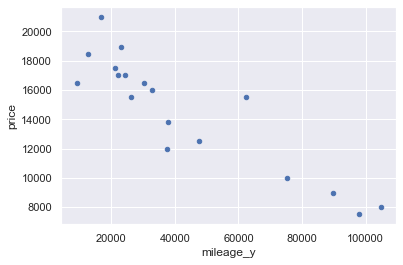

In [22]:
import seaborn as sns
sns.set()

# negative relationship between mileage and price
df_all.merge(X, left_index=True, right_index=True).plot(x='mileage_y', y='price', kind='scatter')